**BETEL**

In [1]:
from functions.functions import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv
import time
import os
sns.set()

# Regression data

To replicate the results contained in the paper, we generate a sample of 250 observations from the regression model $y_i = \alpha + \beta x_i + z_i$ with $z_i \sim \mathcal{N}(0.5,1)$, $\alpha=0$, $\beta=1$ and :

$$e_i \sim \left\{
\begin{array}{l}
  \mathcal{N}(0.75,0.75^2) \\
 \mathcal{N}(-0.75,1.25^2)
\end{array}
\right.$$

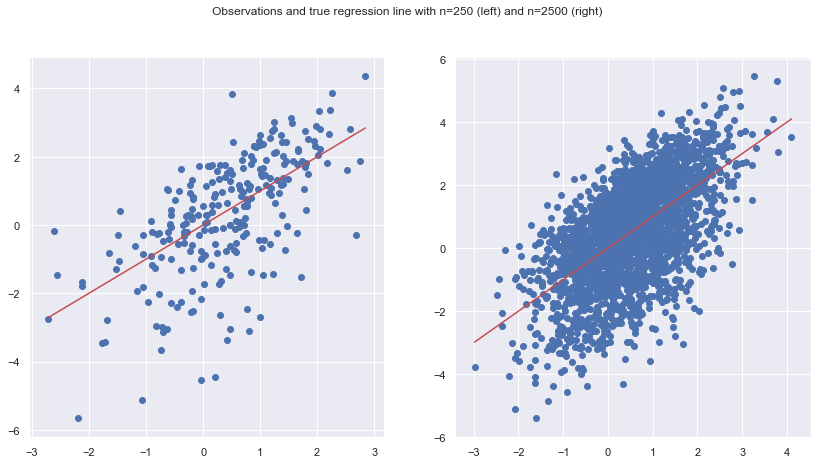

In [2]:
np.random.seed(1235)
n=250
n1 = 2500
z, y = generate_regression(n,alpha=0,beta=1)
z1, y1 = generate_regression(n1,alpha=0,beta=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
x = np.linspace(np.min(z),np.max(z),2)
x1 = np.linspace(np.min(z1),np.max(z1),2)
ax1.plot(x,x, c="r")
ax2.plot(x1,x1, c="r")
ax1.scatter(z,y)
ax2.scatter(z1,y1)
fig.suptitle('Observations and true regression line with n=250 (left) and n=2500 (right)')
plt.show()

# Proposition function : Student Distribution

The proposition function for Metropolis Hasting is important as a poor choice will make MH rejects all the samples. The paper mentions that an appropriate choice for $q$ is a Student distribution with the mode of the logETEL function for the location parameter and the negative inverse of the logETEL at the mode for the scaling parameter.

## Computation of the Mode (location)

We use two methods: a GridSearch and a Gradient based approach. The first one is not robust as it requires to know the true parameters to be efficient.

### Grid Search

Fist we perform a GridSearch. This approach is not robust as the GridSearch is extremely long and we therefore need to use our knowledge of the true parameters (which is not possible in practice) to reduce the search space.


In [6]:
t = 20
alpha_s = np.linspace(-1,1,t)
beta_s = np.linspace(0,2,t)
v_s = np.linspace(-1,1,t)
res = np.zeros((t,t,t))
c=0

In [52]:
for ix,i in enumerate(alpha_s):
    for jx,j in enumerate(beta_s):
        for lx,l in enumerate(v_s):
            x=np.array([i,j,l])
            v,_,_ =calculate_posterior(x,y,z)
            if v==None:
                continue
            res[ix,jx,lx] = v
            c+=1
            if c%50==0:
                print(c)
                
#np.save("./log/grid",res)

One advantage of the Gridsearch is that it allows us to display a contour plot of the logETEL function.
Asymptotically the ETEL function is a Gaussian Distribution thus the logETEL function should have a contour plot that looks like ellipsoïds. We show empirical evidence of this fact by displaying the contour plots in the coordinates ($\alpha, \beta$).

In [11]:
# Load previous computations

# with n = 250 
res=np.load("./log/grid.npy")

# with n = 2500
res2500=np.load("./log/grid2500.npy")

In [12]:
def plot_res(res):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    fig.suptitle('Heatmap (left) and contour plot (right) of the logETEL function in (alpha,beta) for n=250')
    v_pos = 0
    x_axis_labels = np.round(alpha_s,1) # labels for x-axis
    y_axis_labels = np.round(beta_s,1) # labels for y-axis
    # Heat Map
    sns.heatmap(res[:,:,v_pos], xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax1)
    # Contour plot
    X, Y = np.meshgrid(x_axis_labels, y_axis_labels)
    ax2.contour(X, Y, res[:,:,v_pos],25,cmap='plasma')
    plt.show()

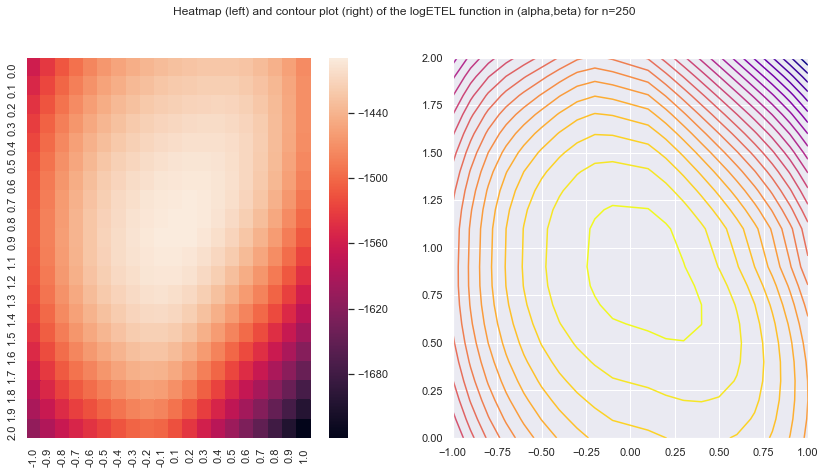

In [13]:
plot_res(res)

Avec n=2500 les courbe de niveaux ressemblent plus a des ellipsoids

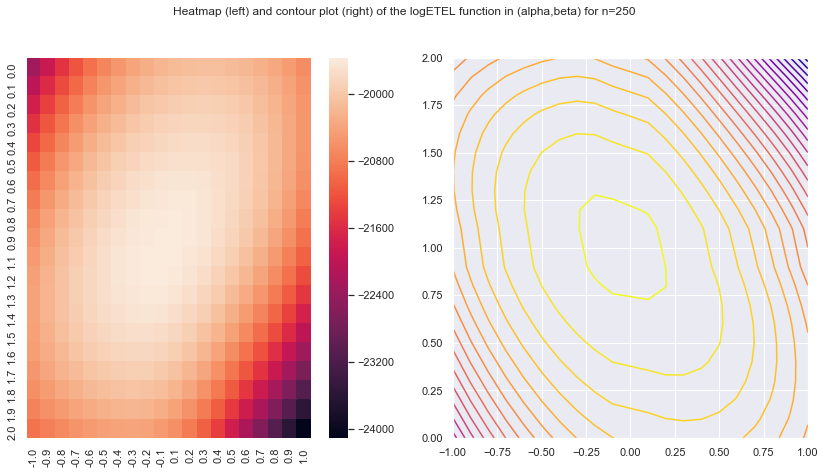

In [14]:
plot_res(res2500)

In [15]:
# Get the mode
res[res==0]=-np.infty
print(np.max(res),np.argmax(res))
a,b,c = np.unravel_index(np.argmax(res, axis=None), res.shape)
print("Mode: ", alpha_s[a], beta_s[b], v_s[c])

-1389.3839489222687 3400
Mode:  -0.1578947368421053 1.0526315789473684 -1.0


## Approximate Gradient ascent

The second approach is to use gradient ascent, we start form an initialisation parameter $x_0$ and we perform the following gradient updates, $$x_{t+1} = x_t + \lambda \nabla f(x_t)$$ where $f$ is the logETEL function. Since we do not have analytic expressions for $\nabla f$ we need to approximate it with the formula $$\nabla f(x)_i \sim \frac{f(x + h e_i) - f(x)}{h}$$

In [91]:
def approx_gradient_ascent(x,y,z,h=1e-2,lambd=1e-3,step=100, model="M1"):
    '''Perform gradient ascent with approximation of the gradient'''
    
    d=3
    e = np.array([[1,0,0],[0,1,0],[0,0,1]])
    l = [] 
    
    for t in range(step):
    
        # Store the gradient
        G = np.zeros(d)
        for i in range(d):
                #print(x,h)
                f1,_,_ = calculate_posterior(x+h*e[i],y,z,model)
                f,_,_ = calculate_posterior(x,y,z,model)
                G[i] = (f1-f)/h
                
        if t%20==0:
            print("Likelihood : {} ({}/{})".format(f,t+1,step))
            print("Value : {} ({}/{})".format(x,t+1,step))
                
        x = x + lambd * G
        l.append(f)
    
    return x,l

In [97]:
x = np.array([-1,2,-2]) # Initialisation

tic = time.time()
x,l = approx_gradient_ascent(x,y,z)
toc=time.time()
print(toc-tic)

Likelihood : [-1480.68456218] (1/100)
Value : [-1  2 -2] (1/100)
Likelihood : [-1388.70413976] (21/100)
Value : [-0.3152236   1.19596665 -1.97330243] (21/100)
Likelihood : [-1386.4765617] (41/100)
Value : [-0.15730605  1.07823908 -1.96422248] (41/100)
Likelihood : [-1386.37809966] (61/100)
Value : [-0.12684308  1.05338181 -1.95288803] (61/100)
Likelihood : [-1386.36851286] (81/100)
Value : [-0.12123493  1.04906275 -1.9419179 ] (81/100)
29.31391477584839


In [100]:
f,_,_ = calculate_posterior(x,y,z)
print("Final value", x, f)

Final value [-0.120003    1.04836209 -1.93186651] [-1386.36280536]


We see that this approach is more robust as it converges even if we start from an initial point far from the true value of the parameters. The fact that the ETEL function approximates a Gaussian distribution makes the gradient ascent quite simple, the convergence towards the mode necessitates less than 50 iterations which is way faster than the gridSearch.

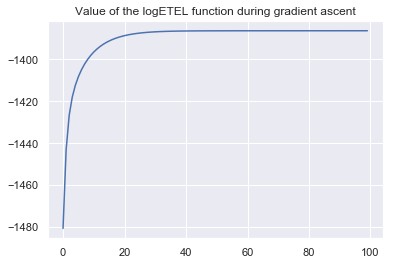

In [101]:
plt.plot(l)
plt.title("Value of the logETEL function during gradient ascent")
plt.show()

### Scaling parameter

We have the mode and we need to obtain the Hessian of the logETEL at the Mode. Since we do not have access to the Gradient nor the Hessian we make the following second order approximation: $$\tilde{H}_{i,j}(x) = \frac{f(x+h_1e_i+h_2e_j) - f(x+h_1e_i) - f(x+h_2e_j) + f(x)}{h_1 \times h_2} $$
As this approximation might not be symmetric, we symmetrise it with $$\hat{H} = \frac{\tilde{H} + \tilde{H}^T}{2}$$

We then take the negative inverse of this quantity for our scaling parameter.

In [102]:
mean=x.copy()
cov = -inv(approx_hessian(mean[0],mean[1],mean[2],y,z))
print(mean)
print(cov)

[-0.120003    1.04836209 -1.93186651]
[[ 0.00887341 -0.00364671  0.0064503 ]
 [-0.00364671  0.00729321  0.0008542 ]
 [ 0.0064503   0.0008542   0.19759095]]


# Metropolis Hasting

In [104]:
tic = time.time()
sample = metropolis(11000,1000,y,z, mean, cov)
toc = time.time()
print("time: {}".format(toc-tic))
#np.save("./log/res_metro2500",sample)

iteration number:  1
iter:  1 coeffs:  -0.04458315302439572 0.8719400025408246 -1.7633781711587837
iteration number:  51
iter:  51 coeffs:  -0.2322721544912113 1.0503048422263626 -1.7310019718896987
iteration number:  101
iter:  101 coeffs:  -0.04974983085756919 1.0732256257703858 -1.6403569596921077
'NoneType' object is not subscriptable
iteration number:  151
iter:  151 coeffs:  -0.15689737567106063 1.0751258287721561 -1.8641349204013329
iteration number:  201
iter:  201 coeffs:  -0.029696261746071817 1.1192217155256767 -1.4364964656953942
iteration number:  251
iter:  251 coeffs:  -0.22623486357083292 1.0561474655662006 -1.2827085620253404
iteration number:  301
iter:  301 coeffs:  -0.04840327932347763 1.0267035502200772 -1.7786283789306971
iteration number:  351
iter:  351 coeffs:  -0.07353523552356456 1.1020539180806663 -1.7884221260044164
iteration number:  401
iter:  401 coeffs:  -0.24658223106405652 1.0933009830028044 -2.913543739973626
iteration number:  451
iter:  451 coeffs:

iteration number:  3951
iter:  3951 coeffs:  -0.02005292126239651 1.023519902983699 -1.679795422479737
iteration number:  4001
iter:  4001 coeffs:  -0.29816484823144457 0.9528584541350388 -1.7715791438668367
iteration number:  4051
iter:  4051 coeffs:  -0.1851434887240906 1.277354154210658 -1.4567027993631294
iteration number:  4101
iter:  4101 coeffs:  -0.06461437509269305 1.0989517914784683 -2.1097911460112724
iteration number:  4151
iter:  4151 coeffs:  -0.03702605736253792 0.9677111763172965 -1.8935354856570483
iteration number:  4201
iter:  4201 coeffs:  -0.2040183846998589 1.23856325303975 -1.3335684740780467
iteration number:  4251
iter:  4251 coeffs:  -0.08801467043345752 1.0904362680648725 -2.050113399643308
iteration number:  4301
iter:  4301 coeffs:  -0.21789199438206353 1.146425869490952 -1.4878522411841717
iteration number:  4351
iter:  4351 coeffs:  0.010985626617758357 1.0760697340482142 -2.079132670008089
iteration number:  4401
iter:  4401 coeffs:  -0.1963910639946858 

iteration number:  7901
iter:  7901 coeffs:  -0.04647640249176435 1.0199201430583849 -1.7272462309730872
iteration number:  7951
iter:  7951 coeffs:  -0.1112624267867134 1.1118837950047542 -1.4675393398571352
iteration number:  8001
iter:  8001 coeffs:  -0.1674293944541494 0.9594991933855173 -2.348742318706612
iteration number:  8051
iter:  8051 coeffs:  -0.024097352569784805 1.0114771002616731 -1.9995197212466251
iteration number:  8101
iter:  8101 coeffs:  -0.08374004240441331 1.1228966120386752 -1.6006317551338087
iteration number:  8151
iter:  8151 coeffs:  -0.07402657064704476 1.013446077096994 -1.9636545277076003
iteration number:  8201
iter:  8201 coeffs:  0.03256787599075579 0.9152478127620759 -1.418308131012632
iteration number:  8251
iter:  8251 coeffs:  -0.21140195287020003 1.0394024655027303 -1.6496975788603045
iteration number:  8301
iter:  8301 coeffs:  -0.1515459422523849 1.0563697406013184 -2.2128752986962805
iteration number:  8351
iter:  8351 coeffs:  0.07292426032367

In [16]:
sample=np.load("./log/res_metro2500.npy")
print(sample.shape)

(10000, 3)


In [17]:
nan_idx = np.argwhere(np.isnan(sample))
sample2=np.delete(sample,nan_idx)
sample2 = sample[~np.isnan(sample).any(axis=1)]
print(sample2.shape)
print(np.mean(sample2[:,1]),np.max(sample2[:,]),np.std(sample2[:,2]))

(10000, 3)
0.9529313190799085 1.0476234842443914 0.11517480566930967


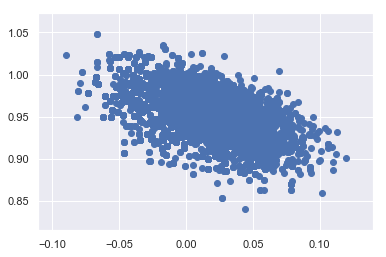

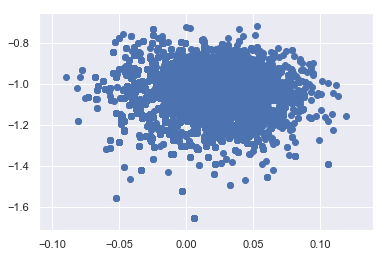

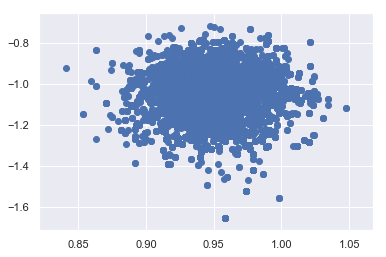

In [18]:
# belle ellipse de confiance
for i,j in [[0,1],[0,2],[1,2]]:
    plt.scatter(sample2[:,i],sample2[:,j],zorder=2)
    plt.show()

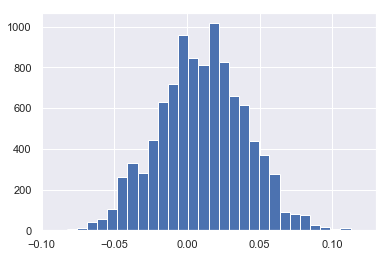

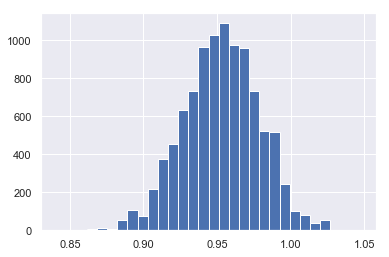

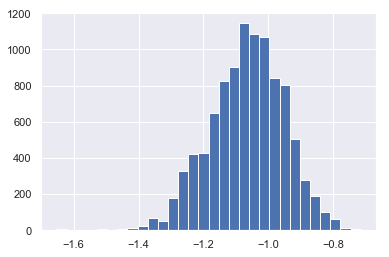

In [19]:
#belle normale
for i in range(sample2.shape[1]):
    plt.hist(sample2[:,i],bins=30)
    plt.show()

# Model Selection for the Regression model

In [ ]:
#calculate log mx for several generations save at every iteration
#génération de données, dans l'idéal on veut faire ça pour plusieurs générations différentes
user=""
n = 250
res=np.zeros
for i in range(80):
  print("iteration_",i)
  m1,m2=-1,-1
  z, y = generate_regression(n,alpha=0,beta=1)
  try:
    m1=marginal("M1",y,z)
    m2=marginal("M2",y,z)
  except:
    res=np.array([m1,m2])
    np.save("log/{}_marginals_{}.npy".format(user,time.time()),res)
    continue
  res=np.array([m1,m2])
  np.save("log/{}_marginals_{}.npy".format(user,time.time()),res)
